## Redemption Decay Functions for Reconciliation Estimation

DATASET CONSTRUCTION INFORMATION


This file describes the creation of the initial dataset used to model coupon redemption for Bayer.
Monthly finance reports were provided by Bayer. Each report contained a list of coupons, issue dates,
and redemption numbers. The reports were combined into one large dataset. Only coupons with data
greater than 30 days since issue were included. Three variables, two final and one intermediate, were created.

1. Sum_PERIOD-QTY: contained the sum total of redemptions for each coupon for all periods.
2. Total_Dist_Percent: each period's redemption per coupon divided by the Sum-Period-QTY.
3. Days_Since_Issue: calculated the number of days since coupon issue.

Variables 2 and 3 were used in the Python program.

NOTE: the data provided was monthly. This prevented modeling the first few weeks of any given coupon, meaning coupon forecasting
is only possible after 30 days. Also, after filtering criteria, some coupon types did not have enough samples for accurate modeling,
and were either grouped together by similarity or defaulted to Budget Cost Life.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit as cf
from datetime import date

In [11]:
def func(x, a, b):
    """
    This function defines the formula
    That we are optimizing, note that since
    The exponential function (non-normalized)
    "Has two parameters" of interest
    :param x: Percentage completed redemption in one period
    :param a: constant coefficient
    :param b: coefficient for x in the exponent of e
    :return: returns a and b, the best estimates for the curve
    """
    return a * np.exp(-b * (x))

In [12]:
def r_squared(x, y, a, b):
    """
    Calculates r-squared, accurate for fitting best fit line
    :param x: x observations
    :param y: y observations
    :param a: coefficient estimate returned from func
    :param b: coefficient estimate returned from func
    :return: r-squared calculation and printout
    """
    res = y - func(x, a, b)
    ss_r = np.sum(res ** 2)
    ss_tot = np.sum((y - np.mean(y) ** 2))
    r_sq = np.round((1 - (ss_r / ss_tot)), 4)
    print(f'R^2 = {r_sq}')
    print(f'Curve Formula: y={a}*exp^(-{b}*(x)')

In [13]:
def plot_curve(x, y, a, b):
    """
    Converts the existing x and y data and the
    best fit curve parameters a and b to create
    a plot
    :param x:
    :param y:
    :param a:
    :param b:
    :return:
    """
    x_est = np.arange(min(x), max(x))
    y_curve = a*np.exp(-b*x_est)
    plt.figure(figsize=(8,8))
    plt.scatter(x, y, s=12)
    plt.plot(x_est, y_curve, '--', color='red')
    plt.show()

In [14]:
def output(x, y, p0):
    """
    This combines all the functions and
    creates the plot, formula for estimates
    and r-squared
    :param x: x data
    :param y: y data
    :param p0: interval in which the curve-fitting
    function begins its search
    :return: plot of data against estimate, model formula
    estimate, and r-squared
    """
    popt, pcov = cf(func, x, y, p0)
    a = np.round(popt[0], 5)
    b = np.round(popt[1], 5)
    r_squared(x, y, a, b)
    plot_curve(x, y, a, b)
    return a, b

#### Creation of file for Curve Formula
1. Read in the financial data (either monthly or weekly)
2. Calculate the Time Since Issue separately (it will be different for every report)
3. Append all reports
4. Drop all observations with start dates before the issuance of the first report and after the last
5. Using the last cumulative redemption count, divide the observation from each report by number
6. Subtract each reports percentage from 1 to get y-axis values
7. Visualize days since issue on the x-axis and the percentage on the y-axis
8. This scatter plot, separated by offer type, is what the curve fitting portion fits to

In [15]:
os.chdir('C:/Users/norri/Desktop/Kroger/Kroger_Raw/')

In [16]:
afrin = pd.read_csv('Afrin_LCM.csv')
afrin['Week Cpn'] = afrin['Net Cpn Prd']

In [17]:
afrin_bg = afrin.groupby(['Coupon'])['Week Cpn'].sum().reset_index()
afrin_bg = afrin_bg.rename(columns=({"Week Cpn": "Temp Week Cpn"}))

In [18]:
afrin_bg = afrin_bg.merge(afrin, on='Coupon')
afrin_bg.drop(columns=['Period Date'], axis=1)

,Coupon,Temp Week Cpn,Net Cpn Prd,Net Amt Prd,Net Cpn Cum,Net Amt Cum,Week,% of Total Cpns,Week Cpn
0,22239.0,1967.0,55.0,61.35,55.0,61.35,1.0,2.80,55.0
1,22239.0,1967.0,511.0,572.09,566.0,633.44,2.0,25.98,511.0
2,22239.0,1967.0,462.0,519.33,1028.0,1152.77,3.0,23.49,462.0
3,22239.0,1967.0,402.0,458.34,1430.0,1611.11,4.0,20.44,402.0
4,22239.0,1967.0,354.0,405.53,1784.0,2016.64,5.0,18.00,354.0
...,...,...,...,...,...,...,...,...,...
198,23673.0,1390.0,84.0,99.09,84.0,99.09,1.0,6.04,84.0
199,23673.0,1390.0,559.0,651.68,643.0,750.77,2.0,40.22,559.0
200,23673.0,1390.0,450.0,527.63,1093.0,1278.40,3.0,32.37,450.0
201,23673.0,1390.0,199.0,228.74,1292.0,1507.14,4.0,14.32,199.0


In [19]:
afrin_bg = afrin_bg.rename(columns=({"Net Cpn Cum": "Cpn Total"}))

In [43]:
afrin_bg['Percentage']  = afrin_bg['Week Cpn'] / afrin_bg['Coupon'] * 100

In [21]:

# report_0121 = pd.read_excel('Finance Total Report 2021-1.xlsx')
# report_0221 = pd.read_excel('Finance Total Report 2021-2.xlsx')
# report_0321 = pd.read_excel('Finance Total Report 2021-3.xlsx')
# report_0421 = pd.read_excel('Finance Total Report 2021-4.xlsx')
# report_0521 = pd.read_excel('Finance Total Report 2021-5.xlsx')
# report_0621 = pd.read_excel('Finance Total Report 2021-6.xlsx')

NameError: name 'afrin_lcm_bg' is not defined

In [22]:
# report_0121 = report_0121[report_0121['ISSUE DATE'] != '00/00/0000']
# report_0121['Report_Date'] = date(2021, 1, 31)
# report_0121['Time_Since_Issue'] = (report_0121['Report_Date'] - pd.to_datetime(report_0121['ISSUE DATE']).dt.date).dt.days

In [23]:
# report_0221 = report_0221[report_0221['ISSUE DATE'] != '00/00/0000']
# report_0221['Report_Date'] = date(2021, 2, 28)
# report_0221['Time_Since_Issue'] = (report_0221['Report_Date'] - pd.to_datetime(report_0221['ISSUE DATE']).dt.date).dt.days

In [24]:
# report_0321 = report_0321[report_0321['ISSUE DATE'] != '00/00/0000']
# report_0321['Report_Date'] = date(2021, 3, 31)
# report_0321['Time_Since_Issue'] = (report_0321['Report_Date'] - pd.to_datetime(report_0321['ISSUE DATE']).dt.date).dt.days

In [25]:
# report_0421 = report_0421[report_0421['ISSUE DATE'] != '00/00/0000']
# report_0421['Report_Date'] = date(2021, 4, 30)
# report_0421['Time_Since_Issue'] = (report_0421['Report_Date'] - pd.to_datetime(report_0421['ISSUE DATE']).dt.date).dt.days

In [26]:
# report_0521 = report_0521[report_0521['ISSUE DATE'] != '00/00/0000']
# report_0521['Report_Date'] = date(2021, 5, 31)
# report_0521['Time_Since_Issue'] = (report_0521['Report_Date'] - pd.to_datetime(report_0521['ISSUE DATE']).dt.date).dt.days

In [27]:
# report_0621 = report_0621[report_0621['ISSUE DATE'] != '00/00/0000']
# report_0621['Report_Date'] = date(2021, 6, 30)
# report_0621['Time_Since_Issue'] = (report_0621['Report_Date'] - pd.to_datetime(report_0621['ISSUE DATE']).dt.date).dt.days

In [28]:
# reports = pd.concat([report_0121,report_0221,report_0321,report_0421,report_0521,report_0621])

In [29]:
# start_date = date(2021, 1, 1)
# end_date = date(2021, 6, 30)

In [30]:
# reports = reports[['OFFER CODE', 'ISSUE DATE', 'EXPIRATION DATE',
#                            'MEDIA LONG DESCRIPTION', 'CUM QTY', 'Time_Since_Issue']]

In [31]:
reports = reports[reports['EXPIRATION DATE'] != 'NONE']
reports = reports[reports['EXPIRATION DATE'] != '00/00/0000']
reports['ISSUE DATE'] = pd.to_datetime(reports['ISSUE DATE']).dt.date
reports['EXPIRATION DATE'] = pd.to_datetime(reports['EXPIRATION DATE']).dt.date
reports = reports[reports['ISSUE DATE'] > start_date]
reports = reports[reports['EXPIRATION DATE'] < end_date]
reports = reports[reports['CUM QTY'] > 0]

NameError: name 'reports' is not defined

In [32]:
reports['Offer_Count'] = reports.groupby('OFFER CODE')['OFFER CODE'].transform('count')
reports.sort_values(by=['OFFER CODE', 'CUM QTY'])

NameError: name 'reports' is not defined

In [33]:
reports['QTY_MAX'] = reports.groupby('OFFER CODE')['CUM QTY'].transform(max)
reports['Total_Dist_Percent'] = 1 - reports['CUM QTY'] / reports ['QTY_MAX']

NameError: name 'reports' is not defined

In [34]:
reports = reports[['Time_Since_Issue', 'MEDIA LONG DESCRIPTION', 'Total_Dist_Percent']]

NameError: name 'reports' is not defined

In [35]:
reports = reports.rename(columns={'MEDIA LONG DESCRIPTION': 'Media_Type'})

NameError: name 'reports' is not defined

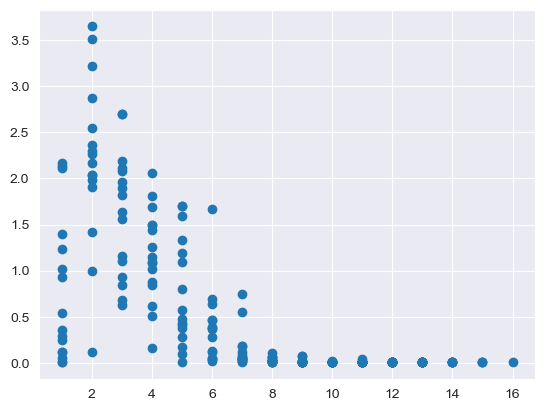

In [57]:
x = afrin_bg['Week']
y = afrin_bg['Percentage']
plt.scatter(x, y)

By stacking each month's coupon redemption data, you will be able to generate a formula
that will tell you what percentage of the total coupon redemption
remains, and therefore how much more money should be allocated to said coupon

In [37]:
# Load Bayer Curves
# Data has media type to break into appropriate groups and run curves

all_coupons = pd.read_csv('/home/matt/DataspellProjects/mercury-ds/attribution/Bayer/bayer_curves.csv')
p0 = [1.0, .05]
print(all_coupons.nunique())
print(all_coupons['Media_Type'].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: '/home/matt/DataspellProjects/mercury-ds/attribution/Bayer/bayer_curves.csv'

In [58]:
p0 = [1.0, .05]

In [59]:
#Sunday FSI Curve, creates subset based on media type (or coupon type)
afrin_bg['Week'] = afrin_bg['Week'].to_numpy(dtype=float)
afrin_bg['Percentage'] = afrin_bg["Percentage"].to_numpy(dtype=float)

In [60]:
# Takes the subset by media type and reduces it into a numpy array
# containing the Time Since Issue and Total Distribution Percent data
x = afrin_bg[:, 0]
y = afrin_bg[:, 1]

InvalidIndexError: (slice(None, None, None), 0)

Afrin& Fit Chart
R^2 = -0.5427
Curve Formula: y=2.16318*exp^(-0.2292*(x)


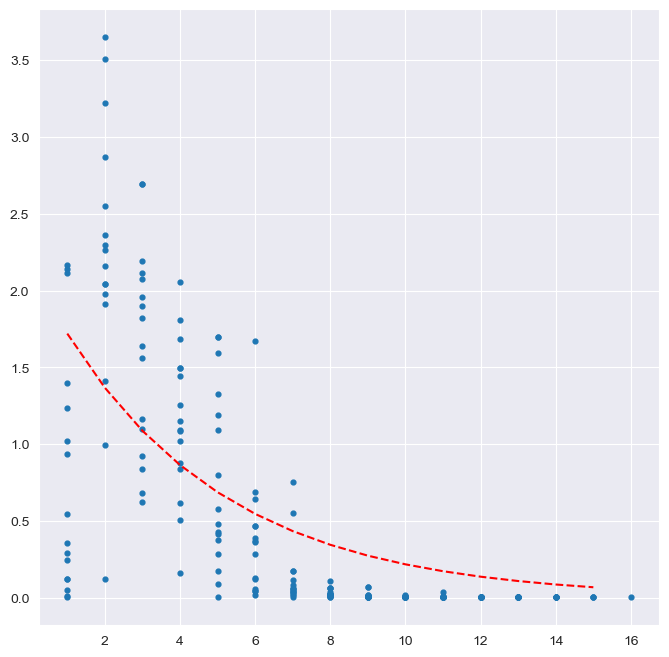

In [61]:
# Provides plots and estimates
print('Afrin& Fit Chart')
a, b = output(x, y, p0)

In [ ]:
Afrin, creates estimates based on brand
sun_fsi = all_coupons[all_coupons["Media_Type"] == "Sunday Fsi"]
np_sun_fsi = sun_fsi[['Time_Since_Issue', 'Total_Dist_Percent']].to_numpy(dtype=float)

# Takes the subset by media type and reduces it into a numpy array
# containing the Time Since Issue and Total Distribution Percent data
x = np_sun_fsi[:, 0]
y = np_sun_fsi[:, 1]

# Provides plots and estimates
print('Sunday FSI R^2 & Fit Chart')
a, b = output(x, y, p0)

In [ ]:
#@title
# Paperless Curve
paperless = all_coupons[all_coupons["Media_Type"] == "Paperless"]
np_paperless = paperless[['Time_Since_Issue',
                          'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_paperless[:, 0]
y = np_paperless[:, 1]

print('Paperless R^2 & Fit Chart')
a, b = output(x, y, p0)

In [ ]:
#@title
# Paperless + Print At Home, Print at Home, Paperless + Print at Home Curve

paper_print = all_coupons[all_coupons["Media_Type"].isin(["Paperless + Print at Home",
                                                          "Print At Home",
                                                          "Paperless + Print at Home + Handout"])]

np_paper_print = paper_print[['Time_Since_Issue', 'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_paper_print[:, 0]
y = np_paper_print[:, 1]

print('Paperless + Print Group R^2 & Fit Chart')
a, b = output(x, y, p0)

In [ ]:
#@title
# HANDOUT, HANDOUT IN-STORE, HANDOUT IN-STORE DISPLAY, HANDOUT IN-STORE TEARPAD,
# HANDOUT SHELF DISPENSER, HANDOUT WITH SAMPLE, INSTANT ON-PACK,
# INSTANT ON-PACK FACTORY APPLIED, ON-PACK

handout = all_coupons[all_coupons["Media_Type"].
isin(["Handout", "Handout In-Store",
      "Handout In-Store Display",
      "Handout In-Store Tearpad",
      "Handout Shelf Dispenser",
      "Handout With Samole", "Instant On-Pack",
      "On-Pack"])]

np_handout = handout[['Time_Since_Issue',
                      'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_handout[:, 0]
y = np_handout[:, 1]

print('Handout Group R^2 & Fit Chart')
a, b = output(x, y, p0)

In [ ]:
#@title
# All Other: MISCELLANEOUS MEDIA, DIRECT MAIL, DIRECT MAIL SOLO

misc = all_coupons[all_coupons["Media_Type"].isin(["Miscellaneous Media",
                                                    "Direct Mail Solo",
                                                    "Direct Mail"])]

np_misc = misc[['Time_Since_Issue',
                'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_misc[:, 0]
y = np_misc[:, 1]

print('All Other Group R^2 & Fit Chart')
a, b = output(x, y, p0)